# Designing an automatic retrieval evaluator

In [57]:
import os
import argilla as rg
from argilla.client.feedback.schemas.remote.records import RemoteFeedbackRecord
from openai import OpenAI
from pydantic import BaseModel
from tqdm.auto import tqdm
import hashlib
import pandas as pd

In [176]:
class VespaTextBlock(BaseModel):
    """Attributes of text blocks in Vespa"""

    text_block_id: str
    text_block: str
    text_block_window: str


class VespaRankingResult(BaseModel):
    """
    One result returned by Vespa.

    Rank is 0-indexed.
    """

    text_block: VespaTextBlock
    score: float
    rank: int
    ranking_features: dict = {}


## Load annotations in from argilla

In [177]:
workspace_name = "rag_relevance_evaluation"
dataset_name = "rag_retrieval_evaluation"

rg_dataset = rg.load(name=dataset_name, workspace=workspace_name)
len(rg_dataset)

/var/folders/nt/2c78pgv94312v7_mmz24h6kc0000gn/T/ipykernel_77233/3661854430.py:4: UserWarning: Loaded dataset is a `FeedbackDataset`. It's recommended to use `rg.FeedbackDataset.from_argilla(name='rag_retrieval_evaluation', workspace='rag_relevance_evaluation')` instead
  rg_dataset = rg.load(name=dataset_name, workspace=workspace_name)


200

In [178]:
rg_dataset[0].__dict__

{'id': UUID('6910860d-9b76-4ae3-b76c-4832262043c6'),
 'client': <httpx.Client at 0x137f95fd0>,
 'fields': {'query': 'How does the document discuss the role of the military in promoting economic development?',
  'text_block': 'The present global political, economic and security order requires an levels, promoting development through',
  'text_block_window': 'STRENGTHEN INTERNATIONAL RELATIONS\nThe present global political, economic and security order requires an levels, promoting development through\nthe bilateral, regional and multilateral'},
 'metadata': {'document_id': 'CCLW.executive.10183.4768',
  'rank_profile': 'dense_bge_base',
  'score': 0.7203098000671228,
  'rank': 6},
 'vectors': {},
 'responses': [RemoteResponseSchema(id=None, client=None, user_id=UUID('551fd111-dac1-4daa-8ce7-ef2b74f32463'), values={}, status=<ResponseStatus.discarded: 'discarded'>, inserted_at=datetime.datetime(2024, 7, 9, 11, 0, 55, 340207), updated_at=datetime.datetime(2024, 7, 9, 11, 0, 55, 340207)),
 

## Find proportion of time the text block window was used, per annotator

In [179]:
from collections import defaultdict

window_used_by_annotator = defaultdict(list)

for record in rg_dataset:
    for response in record.responses:
        if response.status == "submitted":
            
            used_window = "used-window-for-relevance" in response.values and response.values["used-window-for-relevance"].value == "YES"
            
            window_used_by_annotator[str(response.user_id)].append(used_window)

In [180]:
{user_id: sum(used_windows) / len(used_windows) for user_id, used_windows in window_used_by_annotator.items()}

{'8688ece7-15e7-43fb-8088-383cb3ac2d48': 0.40782122905027934,
 '38ac9824-1776-4fa2-a71c-7cf05890e9da': 0.4585635359116022,
 '551fd111-dac1-4daa-8ce7-ef2b74f32463': 0.06338028169014084}

In [181]:
USERS_EXCLUDE = {
    "551fd111-dac1-4daa-8ce7-ef2b74f32463" # kalyan
} 

In [182]:
def _get_hash(text: str) -> str:
    return hashlib.md5(text.encode()).hexdigest()

def argilla_record_to_vespa_ranking_results(rg_item: RemoteFeedbackRecord) -> tuple[str, list[VespaRankingResult]]:
    """Returns (query, VespaRankingResult) tuples for a given RemoteFeedbackRecord."""
    results = []
    query = rg_item.fields["query"]
    
    for response in rg_item.responses:
        score = None
        
        if str(response.user_id) in USERS_EXCLUDE:
            continue
        
        if response.status == "submitted":
            score=int(response.values["relevance"].value)
        elif response.status == "discarded":
            score = -1
            
        if score is not None:
            results.append(
                VespaRankingResult(
                    text_block=VespaTextBlock(
                        # TODO: text_block_id is not stored in Argilla so we use block text here
                        text_block_id=_get_hash(rg_item.fields["text_block"]),
                        text_block=rg_item.fields["text_block"],
                        text_block_window=rg_item.fields["text_block_window"]
                    ),
                    score=score,
                    rank=-1,
                )
            )
            
    return query, results

argilla_record_to_vespa_ranking_results(rg_dataset[0])

('How does the document discuss the role of the military in promoting economic development?',
 [VespaRankingResult(text_block=VespaTextBlock(text_block_id='a4abae87dcfaf7a9477e104f70f84987', text_block='The present global political, economic and security order requires an levels, promoting development through', text_block_window='STRENGTHEN INTERNATIONAL RELATIONS\nThe present global political, economic and security order requires an levels, promoting development through\nthe bilateral, regional and multilateral'), score=1.0, rank=-1, ranking_features={}),
  VespaRankingResult(text_block=VespaTextBlock(text_block_id='a4abae87dcfaf7a9477e104f70f84987', text_block='The present global political, economic and security order requires an levels, promoting development through', text_block_window='STRENGTHEN INTERNATIONAL RELATIONS\nThe present global political, economic and security order requires an levels, promoting development through\nthe bilateral, regional and multilateral'), score=0.0,

In [183]:
argilla_results_converted = [argilla_record_to_vespa_ranking_results(rg_item) for rg_item in rg_dataset]

In [184]:
len(argilla_results_converted)

200

In [185]:
from collections import Counter

Counter([len(v) for k, v in argilla_results_converted])

Counter({2: 200})

## Set up scorer

In [314]:
openai_client = OpenAI(
    api_key=os.environ["OPENAI_API_KEY"],
)

def get_relevance_judgement(query, passage) -> int:
    """Copied from the Vespa example https://blog.vespa.ai/improving-retrieval-with-llm-as-a-judge/"""
    
    prompt = f"""Given a query and a passage, you must provide a score on an integer scale of 0 to 2 with the following meanings:
    0 = represents that the passage is irrelevant to the query,
    1 = represents that the passage is somewhat relevant to the query, i.e. it contains any information that could help a user find an answer to a query,
    2 = represents that the passage is is highly relevant to the query, i.e. it contains information that either answers the question in the query, or would fully support it with some more context.
    Important Instruction: Assign score 1 if the passage is somewhat related to the query, score 2 if passage is highly relevant. Score 1 if the passage contains any information that could help a user find an answer to a query. If none of the above satisfies give it score 0. If a passage contains *any* information that could help a user find an answer to a query in a neighbouring passage in the same document, you must not give it a score of 0. However, the information must support answering the query or directly provide information that would be useful to contextualise a response. Just containing keywords relevant to a query is not sufficient for a judgement of 1 or 2. If the passage looks like a section heading or table/figure caption that refers to further information, then this should be a 2. Note in some cases, the passage might be missing starts or ends of sentences that are useful to make a relevance judgement. In this case, try to predict the relevance based on the information that is available and what could be in the missing part of the sentence.
    Examples:
    Query: What are the specific steps for implementing a fossil fuel-free electricity sector?
    Passage: The government's commitment to a fossil fuel-free energy system extends to the transport sector, starting with public buses and light duty/passenger vehicles. 
    Effective April 2021, the government's procurement policy is to prioritize the purchase of electric or hybrid vehicles, where possible.
    ##final score: 2
    Query: What are the penalties for tampering with electric meters?
    Passage: so as to abstract or consume or use electricity shall be punishable with imprisonment for a term which may extend to three years or with fine or with both:
    ##final score: 2
    Query: Does this document mention any funding or financial support needed for climate change adaptation?	
    Passage: The amount of energy demand
    financial support
    18,000,000
    ##final score: 1
    Query: What is the Bahamas' National Energy Policy target for renewables in the energy mix by 2030?
    Passage: Intention to use market-based mechanisms to meet contribution. The Government of The Bahamas is willing to explore the potential benefits of market mechanisms and other mechanisms under the UNFCCC process, with a regional approach, that equitably benefit Caribbean countries; that demonstrate environmental integrity, result in real, permanent, additional, verified mitigation outcomes and prevent double counting. The Bahamas unfortunately even though being a signatory to the Kyoto Protocol has limited experience with existing market mechanisms.
    ##final score: 0
    Query: What are the powers of the Director of the Department of Geological Hazards?
    Passage: 18\nPART 5 FUNCTIONS AND POWERS OF THE DIRECTOR OF GEOLOGICAL HAZARDS\nPART 5 FUNCTIONS AND POWERS OF THE DIRECTOR OF GEOLOGICAL HAZARDS
    ##final score: 2
    Query: What are the main barriers to implementing adaptation measures in Guinea-Bissau?	
    Passage: Implementing both mitigation and adaptation measures in Guinea-Bissau is challenging due to a number of barriers. These include a lack of financial resources, limited technical capacity, and a lack of awareness of the importance of climate change adaptation.
    ##final score: 2
    Split this problem into steps:
    Consider the key concepts and intention in the search query.
    Measure how relevant the passage is to the query, given content of the query and the instructions above.
    Final score must be an integer value only.
    Do not provide any code or reasoning in result. Just provide the score.
    Query: {query}
    Passage: {passage}
    ##final score: 
    """
    response = openai_client.chat.completions.create(
      model="gpt-4o",
      temperature=0,
      max_tokens=15,
      messages=[
        {"role": "system", "content": "You are the world's foremost climate policy expert that is tasked with judging the relevance of a passage to a query."},
        {"role": "user", "content": prompt}
      ]
    )
    result = response.choices[0].message.content
    try:
        final_score = int(result.strip())
    except ValueError:
        raise ValueError(f"Could not parse score from response: {result}")
    return final_score


In [315]:
query = "What are the requirements for a person or entity to register as a verifier?"
response = """(b) meets the verifier accreditation criteria, requirements and technical capacity under the UNFCCC and the Paris Agreement; and"""

get_relevance_judgement(query, response)

2

In [316]:
difficult_examples = [
    {
        "query": "What are the powers of the Director of the Department of Geological Hazards?",
        "response_with_window": "18\nPART 5 FUNCTIONS AND POWERS OF THE DIRECTOR OF GEOLOGICAL HAZARDS\nPART 5 FUNCTIONS AND POWERS OF THE DIRECTOR OF GEOLOGICAL HAZARDS",
        "max_human_score": 2,
    },
    
]

for example in difficult_examples:
    query = example["query"]
    response = example["response_with_window"]
    max_human_score = example["max_human_score"]
    print(f"Query: {query}\nResponse: {response}\nHuman score: {max_human_score}\n")
    print(f"Relevance judgement: {get_relevance_judgement(query, response)}\n")

Query: What are the powers of the Director of the Department of Geological Hazards?
Response: 18
PART 5 FUNCTIONS AND POWERS OF THE DIRECTOR OF GEOLOGICAL HAZARDS
PART 5 FUNCTIONS AND POWERS OF THE DIRECTOR OF GEOLOGICAL HAZARDS
Human score: 2

Relevance judgement: 2



## Run scorer against all queries and text blocks in Argilla

This involved some correcting of the Argilla labels as the relevance guidance was written after the annotation task (in the prompt above).

These corrections are imported from 2 CSVs, the code to generate which has been left commented below.

In [317]:
judge_and_human_scores = []

for query, judgements in tqdm(argilla_results_converted):
    if len(judgements) == 0:
        continue
    
    max_human_score = max([judgement.score for judgement in judgements])
    all_human_scores = [judgement.score for judgement in judgements]
    # gpt_judge_score_text_block = get_relevance_judgement(query, judgements[0].text_block.text_block)
    gpt_judge_score_text_block_window = get_relevance_judgement(query, judgements[0].text_block.text_block_window)
    
    judge_and_human_scores.append(
        {
            "query": query,
            "response": judgements[0].text_block.text_block,
            "response_with_window": judgements[0].text_block.text_block_window,
            "max_human_score": max_human_score,
            "all_human_scores": all_human_scores,
            # "gpt_judge_score_text_block": gpt_judge_score_text_block,
            "gpt_judge_score_text_block_window": gpt_judge_score_text_block_window,
        }
    )

  0%|          | 0/200 [00:00<?, ?it/s]

In [318]:
# plot confusion matrix of human vs GPT scores
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

df = pd.DataFrame(judge_and_human_scores)
df = df[df["max_human_score"] != -1]
df["min_human_score"] = df["all_human_scores"].apply(lambda i: min(j for j in i if j != -1))

# TODO: enable me for comparison with window data - but the line in the last cell needs to be uncommented too 
# cm = confusion_matrix(df["max_human_score"], df["gpt_judge_score_text_block"])
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
# plt.xlabel("GPT-4o Judge Score (text block)")
# plt.ylabel("Max Human Score")
# plt.title("Confusion Matrix of Human vs GPT Scores")

In [319]:
n_agreements = df["all_human_scores"].apply(lambda i: len(set(i)) == 1).sum()

n_agreements / len(df)

0.4948453608247423

In [320]:
# Once-run code to generate data to review – left here for reference

# # Where GPT-4o judge score is 0 and max human score is 1
# df_to_review = df[(df["max_human_score"] == 1) & (df["gpt_judge_score_text_block_window"] == 0)]

# questions_to_remove = {
#     "What changes does this document propose compared to previous years?",
#     "What is the purpose of this Act?",
# }

# df_to_review = df_to_review[~df_to_review["query"].isin(questions_to_remove)]

# df_to_review.to_csv("../data/retrieval_eval/retrieval_gpt4_alignment_spot_check.csv", index=False)

# # Where GPT-4o judge score is 1 and max human score is 2
# df_to_review_2 = df[(df["max_human_score"] == 2) & (df["gpt_judge_score_text_block_window"] == 1)]
# df_to_review_2.to_csv("../data/retrieval_eval/retrieval_gpt4_alignment_spot_check_2.csv", index=False)

# # Where GPT-4o judge score is 0 and max human score is 2
df_to_review_3 = df[(df["max_human_score"] == 2) & (df["gpt_judge_score_text_block_window"] == 0)]
df_to_review_3.to_csv("../data/retrieval_eval/retrieval_gpt4_alignment_spot_check_3.csv", index=False)


In [321]:
reviewed_data_1 = pd.read_csv("../data/retrieval_eval/retrieval_gpt4_alignment_spot_check_results.csv")
reviewed_data_2 = pd.read_csv("../data/retrieval_eval/retrieval_gpt4_alignment_spot_check_2_results.csv")
reviewed_data_3 = pd.read_csv("../data/retrieval_eval/retrieval_gpt4_alignment_spot_check_3_results.csv")

reviewed_data = pd.concat([reviewed_data_1, reviewed_data_2, reviewed_data_3])


In [322]:
# replace rows in the original dataframe with the reviewed data
for idx, row in reviewed_data.iterrows():
    query = row["query"]
    response = row["response"]
    
    
    df.loc[(df["query"] == query) & (df["response"] == response), "max_human_score"] = row["score (0-2)"]

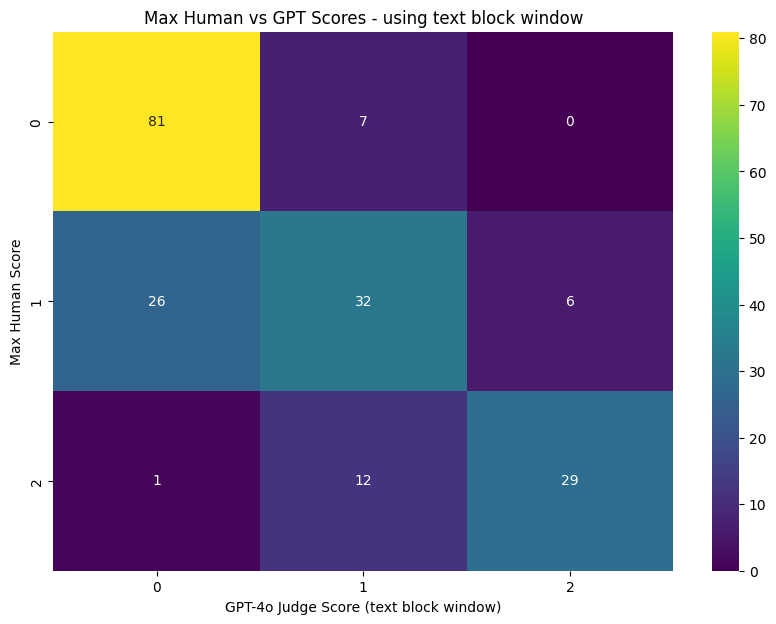

In [323]:
def plot_confusion_matrix(df):
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))

    cm = confusion_matrix(df["max_human_score"], df["gpt_judge_score_text_block_window"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=axs)
    axs.set_xlabel("GPT-4o Judge Score (text block window)")
    axs.set_ylabel("Max Human Score")
    axs.set_title("Max Human vs GPT Scores - using text block window")
    
    return axs

_ = plot_confusion_matrix(df)

### Binary relevance

The `0-2` relevance scale is a bit confusing, as we don't really want passages with a relevance of 1 in our RAG prompts.

So, what happens if we reduce the relevance scale to binary, mapping `{0,1} -> 0` and `2 -> 1`?

In [324]:
df_binary_relevance = df.copy(deep=True)
df_binary_relevance["max_human_score"] = df_binary_relevance["max_human_score"].apply(lambda i: 1 if i > 1 else 0)
df_binary_relevance["gpt_judge_score_text_block_window"] = df_binary_relevance["gpt_judge_score_text_block_window"].apply(lambda i: 1 if i > 1 else 0)

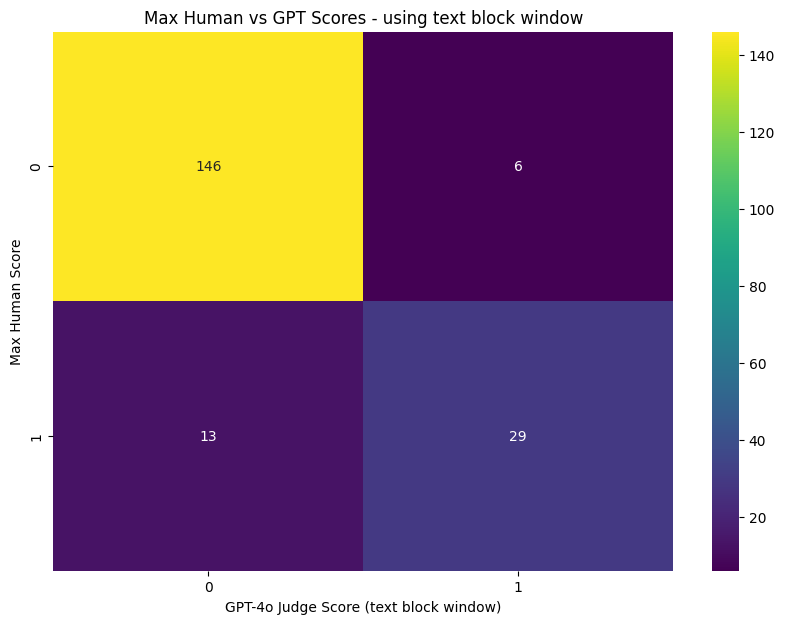

In [325]:
_ = plot_confusion_matrix(df_binary_relevance)

In [326]:
precision = df_binary_relevance[df_binary_relevance["gpt_judge_score_text_block_window"] == 1]["max_human_score"].mean()
recall = df_binary_relevance[df_binary_relevance["max_human_score"] == 1]["gpt_judge_score_text_block_window"].mean()

f1 = 2 * (precision * recall) / (precision + recall)

precision, recall, f1

(0.8285714285714286, 0.6904761904761905, 0.7532467532467533)

In [327]:
with pd.option_context("display.max_colwidth", None):
    display(df_binary_relevance[(df_binary_relevance["max_human_score"] == 1) & (df_binary_relevance["gpt_judge_score_text_block_window"] == 0)][["query", "response_with_window"]])

,query,response_with_window
27,What are the specific steps for implementing a fossil fuel-free electricity sector?,"BARBADOS 2021 UPDATE OF THE FIRST NATIONALLY DETERMINED CONTRIBUTION\nThe government's commitment to a fossil fuel-free energy system extends to the transport sector, starting with public buses and light duty/passenger vehicles.\nEffective April 2021, the government's procurement policy is to prioritize the purchase of electric or hybrid vehicles, where possible. The government-owned transport fleet is currently operating 35 EV buses. The Barbados Transport Board's intention is to operate a fully-electrified fleet by 2030. The Transport Board competes with other private operators using minibuses and minivans on the same routes and for the same users. Public transportation is also supported with private taxis, used mostly by the tourism sector."
35,Does this document include estimates for all carbon pools in the Amazon biome?,"The REDD+ decisions under the UNFCCC value the continuous update and improvement of relevant data and information over time. Brazil values consistency and transparency of the data submitted as fundamental and gives the highest priority to these. Nonetheless, Brazil continues its efforts to improve the accuracy of the estimates for all carbon pools included in the FREL. Brazil's data is presented in a transparent and verifiable manner, allowing the reconstruction of the FREL C.\n3. RESULTS IN TONNES OF CO2 PER YEAR, CONSISTENT WITH THE ASSESSED FOREST REFERENCE EMISSION LEVEL FOR THE AMAZON BIOME\nDecision 14/ CP.19, paragraph 3, ""decides that the data and information used by Parties in the estimation of anthropogenic forest-related emissions by sources and removals by sinks, forest carbon stocks, and forest carbon stock and forest-area changes, as appropriate to the activities referred to in decision 1/CP.16, paragraph 70, undertaken by Parties, should be transparent, and consistent over time and with the established forest reference emission levels and/or forest reference levels in accordance with decision 1/CP.16, paragraph 71(b) and (c) and section II of decision 12/CP.17""."
38,What are the specific steps for implementing a fossil fuel-free electricity sector?,"BARBADOS 2021 UPDATE OF THE FIRST NATIONALLY DETERMINED CONTRIBUTION\n. In 2019, the Fair Trading Commission established feed-in-tariffs (FITs) for renewable energy technologies up to 1 MW, and in 2020, established FITs for RE technologies up to 10 MW to replace a temporary tariff arrangement with the utility and provide stable and predictable price signals to potential investors.\n. Until 2018, the CHENACT project, initiated by the Caribbean Tourism Organization, the Caribbean Hotel and Tourism Association and the IDB supported energy audits and efficiency measures in small and medium-sized hotels enabling savings of up to 50% of water usage and 30-50 % of energy bills."
60,What is the process for obtaining a license for electricity generation?,"C- 1- If the business or an asset of an electricity company is transferred to another company which does not hold a licence, the transferee shall be deemed to hold an interim licence for a period not exceeding eighteen months from the date of the contract signed between them on the same terms and conditions as those of the licence of the licensee.\n2- The company holding an interim license in accordance with this paragraph shall apply for a final licence at least three months before the expiry of the term of the interim licence.\nArticle (30) :"
64,What are the strategic objectives of the Floresta+ Program?,Art. 1 The National Program of Payments for Environmental Services - Floresta+ is instituted within the scope of the Ministry of the Environment.\nArt. 2nd The Floresta+ Program will encourage:\nI - the private market for payments for environmental services in areas maintained with native vegetation cover; It is
123,"What are the plans for carbon capture, utilization and storage (CCUS